In [7]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import frozen_lake
import jax
import jax.numpy as jnp
import jax.random as random
import jax
from typing import Optional
from functools import partial
import matplotlib.pyplot as plt
from typing import NamedTuple
from tqdm.auto import tqdm
#jax.config.update("jax_platform_name", "cpu")
jax.devices()

[cuda(id=0)]

In [8]:
from frozen_lake import generate_frozen_chunk, get_preset_map

In [9]:
class FrozenLake:
    def __init__(
        self,
        shape: tuple[int, int],
        frozen_prob: Optional[float] = None,
        rng_key: Optional[jax.Array] = None,
    ):
        if rng_key is None:
            self.frozen = get_preset_map(*shape)
            self.agent_start = jnp.array([[0, 0]])
            self.goal_start = jnp.array([[-1, -1]])
            self.rng_key = jax.random.PRNGKey(0)
        else:
            self.rng_key, subkey1, subkey2 = random.split(rng_key, 3)
            if frozen_prob is None:
                p = random.uniform(subkey1, minval=0.5, maxval=0.8)
            else:
                p = jnp.array(frozen_prob)
            self.frozen = generate_frozen_chunk(subkey2, shape, p)
            self.agent_start = jnp.indices(shape)[:, self.frozen == 1].T
            self.goal_start = jnp.indices(shape)[:, self.frozen == 1].T

    def step(self, action: jax.Array):
        assert action in [0, 1, 2, 3]
        LEFT, DOWN, RIGHT, UP = 0, 1, 2, 3
        delta = jnp.select(
            [action == LEFT, action == DOWN, action == RIGHT, action == UP],
            [jnp.array([0, -1]), jnp.array([1, 0]), jnp.array([0, 1]), jnp.array([-1, 0])],
        )
        new_pos = jnp.clip(self.agent_pos + delta, 0, jnp.array(self.frozen.shape))
        print(new_pos)
        self.agent_pos = new_pos

    def reset(self):
        self.rng_key, subkey1, subkey2 = random.split(self.rng_key, 3)
        self.agent_pos = random.choice(subkey1, self.agent_start)
        self.goal_pos = random.choice(subkey2, self.goal_start)
        return self.agent_pos, {}

    def play(self):
        self.reset()
        self.render()
        while True:
            action = jnp.array({"w": 0, "a": 1, "s": 2, "d": 3}.get(input()))
            if action is None:
                break
            self.step(action)
            self.render()

    def render(self):
        import matplotlib.pyplot as plt

        rows, cols = self.frozen.shape
        plt.figure(figsize=(cols, rows), dpi=60)
        plt.xticks([])
        plt.yticks([])
        # plt the map
        plt.imshow(1 - self.frozen, cmap="Blues", vmin=-0.1, vmax=3)
        # plt the frozen
        y, x = jnp.where(self.frozen == 0)
        plt.scatter(x, y, marker="o", s=3000, c="snow", edgecolors="white")
        # plt the holes
        y, x = jnp.where(self.frozen == 0)
        plt.scatter(x, y, marker="o", s=3000, c="tab:blue", edgecolors="white")
        # plt the goal
        y, x = self.goal_pos
        plt.scatter(x, y, marker="*", s=800, c="orange", edgecolors="black")
        # plt the agent
        y, x = self.agent_pos
        plt.scatter(x, y + 0.15, marker="o", s=400, c="pink", edgecolors="black")
        plt.scatter(x, y - 0.15, marker="^", s=400, c="green", edgecolors="black")
        plt.show()

[2 5]
[2 4]
[2 3]
[2 2]
[2 1]
[2 0]
[2 0]
[2 0]
[2 0]
[2 0]


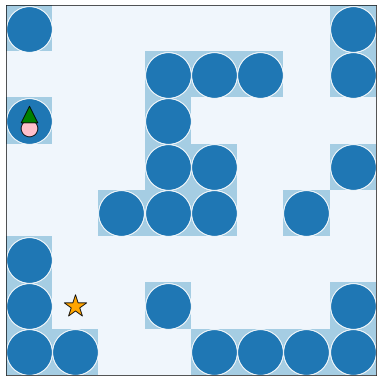

In [21]:
rng_key = random.PRNGKey(seed)
env = FrozenLake((8, 8), rng_key=rng_key, frozen_prob=0.5)
env.reset()
for _ in range(10):
    env.step(0)
    char = input()
    if char == "q":
        break
    if char == "r":
        env.reset()
env.render()